<a href="https://colab.research.google.com/github/SourLemon23/covid19-diagnosis/blob/master/COVID_19_CT_Diagnosis_V7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import cv2
import datetime

import tensorflow as tf
try:
    %tensorflow_version 2.x
except:
    pass

print('Using TensorFlow Version:', tf.__version__)

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard

# Load the TensorBoard notebook extension
%load_ext tensorboard

import matplotlib.pyplot as plt

# EfficientNetB7
! pip install -U efficientnet
from efficientnet.tfkeras import EfficientNetB7

import scipy
print('Using SciPy Version:', scipy.__version__) # Should be 1.1.0

Using TensorFlow Version: 2.3.0
     |████████████████████████████████| 51kB 6.4MB/s 
Using SciPy Version: 1.4.1


In [ ]:
# Check if the hardware accelerator is set to GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# Authorize access to mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Initialize dataset directories (Google Drive)
ct_training_dir   = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V4/Training'
ct_validation_dir = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V4/Validation'
ct_testing_dir    = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V4/Testing'

In [ ]:
# Saved weights
checkpoint_filepath = 'covid19_ct_model.h5'

In [ ]:
# Initialize constants
CLASSES = ['COVID-19 Positive', 'COVID-19 Negative']

# Need 3 grayscale channels to be compatible w/ imagenet weights (RGB)
CHANNELS = 3
COLOR_MODE = 'rgb'
# ---------------------------------------------------------
# Should be 224 x 224? Found online 256 x 256 more popular
# ---------------------------------------------------------
IMG_WIDTH, IMG_HEIGHT = 256, 256
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)

BATCH_SIZE = 50
EPOCHS = 5

METRICS = ['accuracy',
           Precision(name='precision'),
           Recall(name='recall')]

COVID_THRESHOLD = 0.05
EQUIDDST_MEAS = 0.5
NORMAL_THRESHOLD = 0.95

PERCENTAGE_FACTOR = 100;

**Data Preprocessing**

In [374]:
# Crop the image along the contours
def crop_contour(img_path, plot=False):
    img = cv2.imread(img_path)
    img2 = img.copy()

    grayscale_img = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    smoothed_img = cv2.GaussianBlur(grayscale_img, (5, 5), 0)

    binary_img = cv2.threshold(smoothed_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    kernel = np.ones((8, 8), dtype=np.uint8)
    eroded_img = cv2.erode(binary_img, kernel, iterations=1)
    dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(dilated_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(contour) for contour in contours]
    max_index = np.argmax(areas)
    contour = contours[max_index]
    cv2.drawContours(img2, contours, -1, (0, 255, 0), 3)

    x, y, w, h = cv2.boundingRect(contour)
    xmin = x
    xmax = x + w
    ymin = y
    ymax = y + h
    cv2.rectangle(img2, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    cropped_image = img[ymin:ymax, xmin:xmax]

    if plot:
        fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(24, 4), constrained_layout=True)
        
        for i, img_filter in enumerate(['Grayscale', 'Smoothed', 'Binary', 'Eroded', 'Dilated', 'Contoured', 'Cropped']):
            axs[i].set_title(img_filter)

        axs[0].imshow(grayscale_img)
        axs[1].imshow(smoothed_img)
        axs[2].imshow(binary_img)
        axs[3].imshow(eroded_img)
        axs[4].imshow(dilated_img)
        axs[5].imshow(img2)
        axs[6].imshow(cropped_image)

        plt.show()

    return cropped_image

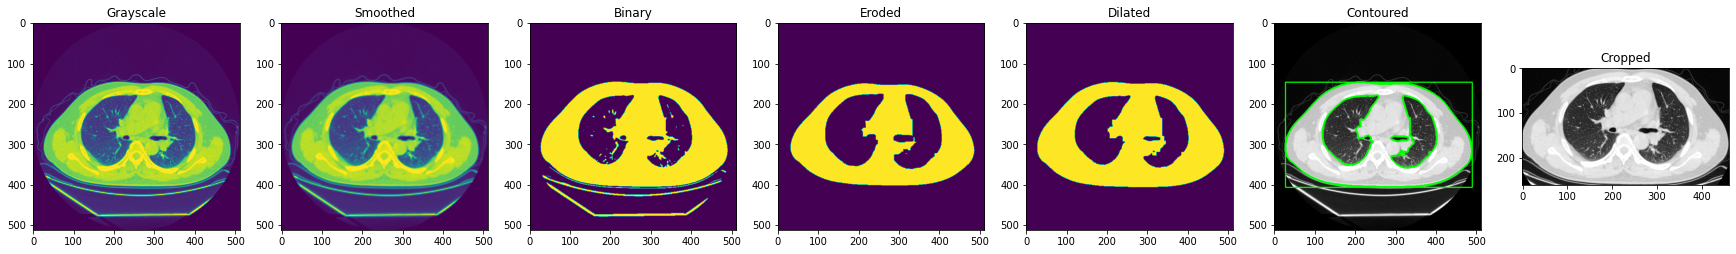

In [375]:
img_path = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V4/Training/covid19/CNCB COVID-19 CT Dataset/NCP (1)/1001/2559/0001.JPG'

cropped_image = crop_contour(img_path, plot=True)

In [ ]:
# test_path = '/content/drive/My Drive/testImg.jpg'

# with open(test_path, 'w') as f:
#     # f.write('sample text')
#     f.write(example_img)

# print('file contains:')
# !cat test_path

In [ ]:
# Augment data
training_data_gen = ImageDataGenerator(rescale=1./255,              # Simplify pixel values to be 0-1
                                       horizontal_flip=True,        # Randomly flip images horizontally
                                       vertical_flip=True,          # Randomly flip images vertically
                                       zoom_range=0.15,             # Randomly zoom
                                       shear_range=0.15,            # Shear angle in counter-clockwise direction
                                       rotation_range=20,           # Randomly rotate
                                       width_shift_range=0.15,      # Randomly shift the image left/right
                                       height_shift_range=0.15,     # Randomly shift the image up/down
                                       brightness_range=(0.3, 1.0)) # Randomly adjust the brightness

validation_data_gen = ImageDataGenerator(rescale=1./255)

testing_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Split data
training_generator = training_data_gen.flow_from_directory(ct_training_dir,
                                                           color_mode=COLOR_MODE,
                                                           target_size=TARGET_SIZE,
                                                           class_mode='categorical',
                                                           batch_size=BATCH_SIZE,
                                                           shuffle=True)

validation_generator = validation_data_gen.flow_from_directory(ct_validation_dir,
                                                               color_mode=COLOR_MODE,
                                                               target_size=TARGET_SIZE,
                                                               class_mode='categorical',
                                                               batch_size=BATCH_SIZE,
                                                               shuffle=True)

testing_generator = testing_data_gen.flow_from_directory(ct_testing_dir,
                                                         color_mode=COLOR_MODE,
                                                         target_size=TARGET_SIZE,
                                                         class_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True)

**Building the Model**

In [ ]:
# Create a neural network
def create_model(print_summary=False):
    # Instantiate a base model with pre-trained weights
    base_model = EfficientNetB7(weights='imagenet',
                                include_top=False,
                                input_shape=INPUT_SHAPE)
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output

    # Add new classifier layers to the end of the base model
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(1024, activation="relu")(x)

    # A final dense layer with a single neuron (binary classification)
    predictions = Dense(1, activation="sigmoid")(x)  

    model = Model(inputs=base_model.inputs, outputs=predictions)

    if print_summary:
        model.summary()

    return model

In [ ]:
# Configure model
def compile_model(model):
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', # tf.keras.optimizers.RMSprop(lr=1e-4)
                  metrics=METRICS)

In [ ]:
# Train the model
def fit_model(model):
    checkpoint_cb = ModelCheckpoint(checkpoint_filepath,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

    early_stopping_cb = EarlyStopping(monitor='val_loss',
                                      min_delta=1e-3,
                                      patience=5,
                                      mode='min',
                                      restore_best_weights=True)

    # https://www.tensorflow.org/tensorboard/get_started
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_cb = TensorBoard(log_dir=log_dir,
                                 histogram_freq=1)
    
    callbacks = [checkpoint_cb, early_stopping_cb, tensorboard_cb]

    history = model.fit(training_generator,
                        epochs=EPOCHS,
                        steps_per_epoch=(training_generator.n/BATCH_SIZE),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/BATCH_SIZE),
                        callbacks=callbacks)
    
    model.load_weights(checkpoint_filepath)
    
    %tensorboard --logdir logs/fit
    
    return history

In [ ]:
# Visualize metrics with graphs
def evaluate_model(history):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 4), constrained_layout=True)
    axs = axs.ravel()

    for i, metric in enumerate(['accuracy', 'loss', 'precision', 'recall']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_' + metric])
        axs[i].set_title('Model {}'.format(metric.capitalize()))
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend(['Training', 'Validation'])

In [ ]:
model = create_model(print_summary=True)
compile_model(model)

In [ ]:
history = fit_model(model)

In [ ]:
evaluate_model(history)

**Predicting Images**

In [ ]:
# testing_img_path = get_testing_image()
# run_diagnosis(model, testing_img_path)

In [ ]:
def convert_img_path_to_array(img_path):
    img = load_img(img_path,
                   color_mode=COLOR_MODE
                   target_size=TARGET_SIZE)
    
    # Convert to Numpy array
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, IMG_WIDTH, IMG_HEIGHT, CHANNELS))

    return img_array

In [ ]:
# Randomly pick and display an unseen image for the network to predict
def get_testing_image():
    # image_index = random.randint(0, len(testing_generator[0][0]))
    # testing_img = testing_generator[0][0][image_index]

    uploaded = files.upload()
   

    return testing_img_path

In [ ]:
# Run a diagnosis to determine if the patient is COVID-19 positive or negative
def run_diagnosis(model, testing_img_path):
    font_settings = {'family': 'DejaVu Sans',
                     'color' : 'red',
                     'weight': 'heavy',
                     'size'  :  15}

    img_array = convert_img_path_to_array(testing_img_path)
    prediction = model.predict(img_array)
    
    if prediction > 0 and prediction < COVID_THRESHOLD:
        class_index = 0
        network_prediction = CLASSES[class_index]

        network_percent_confidence = str(((EQUIDDST_MEAS - prediction) / EQUIDDST_MEAS) * PERCENTAGE_FACTOR)[2:6]

        font_settings.update({'color': 'red'})
        font_settings.update({'size' :  11})
        plt.title(f'{network_prediction} ({network_percent_confidence} % match)', fontdict=font_settings)
        print()

    # Safe prediction for COVID-19 negative
    elif prediction < 1 and prediction > NORMAL_THRESHOLD:
        class_index = 1
        network_prediction = CLASSES[class_index]

        network_percent_confidence = str(((prediction - EQUIDDST_MEAS) / EQUIDDST_MEAS) * PERCENTAGE_FACTOR)[2:6]
        
        font_settings.update({'color': 'blue'})
        font_settings.update({'size' :  11})
        plt.title(f'{network_prediction} ({network_percent_confidence} % match)', fontdict=font_settings)
        print()

    else:
        network_prediction = 'Uncertain'

        font_settings.update({'color': 'yellow'})
        font_settings.update({'size' :  11})
        plt.title(network_prediction, fontdict=font_settings)

    print('Prediction:', prediction)
    
    plt.imshow(testing_image)
    plt.show()

Test internet images (unreliable)

In [ ]:
# Pass into run_diagnosis as a param
font_settings = {'family': 'DejaVu Sans',
                 'color' : 'red',
                 'weight': 'heavy',
                 'size'  :  15}

disclaimer = '*** DISCLAIMER ***\n' \
             'Do not rely on this prediction for self-diagnosis. ' \
             'Please check with your local authority services for ' \
             'seeking medical assistance.'

# ax = plt.axes([.65, .6, .2, .2], facecolor='k')

# a = plt.imread('https://lh3.googleusercontent.com/proxy/GoGROGCSVoylCPBvcWy2y8FtuT86Vzsg0cW7ZqW1EHUoKyyStH9dGdxSZV_ya41mbYGbfmm7PRt1QT-MOIe87tcp-m5glt7kteygIHpyz1VqUh2cCNK3AmMXN2S_dSScog3C3u4u6N1p2vieALS-4g')
# plt.imshow(a)
# plt.show()

# matplotlib.widgets.TextBox(ax, disclaimer, initial='', color='.95', hovercolor='1', label_pad=0.01)
plt.text(0.6, 0.7,
        '*** DISCLAIMER ***\n' \
        'Do not rely on this prediction for self-diagnosis. ' \
        'Please check with your local authority services for ' \
        'seeking medical assistance.',
         size=50,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8))
         )

ct_testing_dir = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/Internet Images'

testing_generator = testing_data_gen.flow_from_directory(ct_testing_dir,
                                                         target_size=TARGET_SIZE,
                                                         class_mode='binary',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=False)

print(testing_generator.labels)

# Loop thorough all the image arrays stored in the DirectoryIterator
for i in range(len(testing_generator[0][0])):
    print(str(i + 1) + ": " + testing_generator.filepaths[i])

    true_label_class_index = testing_generator.labels[i]
    # true_label_class_index = testing_generator[0][1][i]
    true_label = CLASSES[true_label_class_index]

    testing_image = testing_generator[0][0][i]
    img_array = testing_image
    
    # Flatten the array
    img_array = img_array.reshape(1, IMG_WIDTH, IMG_HEIGHT, CHANNELS)

    prediction = model.predict(img_array)
    
    # Safe prediction for COVID-19 positive
    if prediction > 0 and prediction < COVID_THRESHOLD:
        class_index = 0
        network_prediction = CLASSES[class_index]

        network_percent_confidence = str(((EQUIDDST_MEAS - prediction) / EQUIDDST_MEAS) * PERCENTAGE_FACTOR)[2:6]

        font_settings.update({'color': 'red'})
        font_settings.update({'size' :  11})
        plt.title(f'{network_prediction} ({network_percent_confidence} % match)', fontdict=font_settings)
        print()

    # Safe prediction for COVID-19 negative
    elif prediction < 1 and prediction > NORMAL_THRESHOLD:
        class_index = 1
        network_prediction = CLASSES[class_index]

        network_percent_confidence = str(((prediction - EQUIDDST_MEAS) / EQUIDDST_MEAS) * PERCENTAGE_FACTOR)[2:6]
        
        font_settings.update({'color': 'blue'})
        font_settings.update({'size' :  11})
        plt.title(f'{network_prediction} ({network_percent_confidence} % match)', fontdict=font_settings)
        print()

    else:
        network_prediction = 'Uncertain'

        font_settings.update({'color': 'yellow'})
        font_settings.update({'size' :  11})
        plt.title(network_prediction, fontdict=font_settings)
    
    print('True Label:', true_label)
    print('Prediction:', prediction)
    
    plt.imshow(testing_image)
    plt.show()

In [ ]:
# img_path = f'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_xray_dataset/Testing/covid19/Github COVID-19 X-ray Dataset/000001-1.jpg'
# plot_map(grad_top1)

# Upload files to test
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded.keys():
#     # print('User uploaded file "{name}" with length {length} bytes'.format(
#     #     name=filename, length=len(uploaded[filename])))

#     img_path = filename
#     img = load_img(img_path,
#                    color_mode=COLOR_MODE
#                    target_size=TARGET_SIZE)
#     img_array = img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     print(img_array)

In [ ]:
# #@title Enter Filepath Here:
# filename = "/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg" #@param {type:"string"}

# img = image.load_img(filename,
#                      color_mode=COLOR_MODE
#                      target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# y = final_model.predict(x)

# predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
# actual="Normal" if "NORMAL" in filename else "Pneumonia" 

# img=mpimg.imread(filename)
# title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
# plt.title(title_text)
# imgplot=plt.imshow(img)

Confusion Matrix (from https://github.com/haydengunraj/COVIDNet-CT/blob/8599c2a87856326a18bbdf6ffa5987f9c1e64b4b/run_covidnet_ct.py#L213)

In [ ]:
# # Plot confusion matrix
#     fig, ax = plt.subplots()
#     disp = ConfusionMatrixDisplay(confusion_matrix=metrics['confusion matrix'],
#                                   display_labels=CLASS_NAMES)
#     disp.plot(include_values=True,
#               cmap='Blues', ax=ax,
#               xticks_rotation='horizontal',
#               values_format='.5g')
    
#     plt.show()

GRAD-Cam

In [ ]:
# # Grad-CAM
# ! pip install keras==2.2.0
# ! pip install tensorflow==1.10.0
# ! pip install keras==2.2.2 # EfficientNet PyPi
# ! pip install tensorflow==1.12.0 # EfficientNet PyPi

# Versions that are compatible with vis
# ! pip install keras==2.2.4
# ! pip install tensorflow==1.14.0
# ! pip install keras_applications >= 1.0.7
# https://stackoverflow.com/questions/57773636/no-attribute-set-keras-submodules

# ! pip install vis
# ! pip install scipy==1.1.0

In [ ]:
# ! pip install git+git://github.com/raghakot/keras-vis.git --upgrade --no-deps
# import vis

# from vis.utils import utils
# from vis.visualization import visualize_cam

# --------------------------------------------
# FROM https://github.com/raghakot/keras-vis/blob/master/applications/self_driving/visualize_attention.ipynb
# --------------------------------------------
# for i, modifier in enumerate(modifiers):
#     heatmap = visualize_cam(model, layer_idx=-1, filter_indices=0, 
#                             seed_input=bgr_img, grad_modifier=modifier)
#     plt.figure()
#     plt.title(titles[i])
#     # Overlay is used to alpha blend heatmap onto img.
#     jet_heatmap = np.uint8(cm.jet(heatmap)[..., :3] * 255)
#     plt.imshow(overlay(img, jet_heatmap, alpha=0.7))

In [ ]:
# classifier_layer_names = ['top_conv', 'top_bn', 'top_activation', 'global_average_pooling2d_1', 'dropout_1', 'dense_3', 'dense_4', 'dense_5']
# last_conv_layer_name = 'block7d_add'

# img_path = f'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_xray_dataset/Testing/covid19/Github COVID-19 X-ray Dataset/000001-1.jpg'

# img = load_img(img_path,
#                color_mode=COLOR_MODE
#                target_size=TARGET_SIZE)

# img               = img_to_array(img)
# # img               = preprocess_input(img)
# y_pred            = model.predict(img[np.newaxis,...])
# class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
# # topNclass         = 5
# # for i, idx in enumerate(class_idxs_sorted[:topNclass]):
# #     print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
# #           i + 1,classlabel[idx],idx,y_pred[0,idx]))

# # Utility to search for layer index by name. 
# # ***********  Alternatively we can specify this as -1 since it corresponds to the last layer.  ***************
# layer_idx = utils.find_layer_idx(model, 'dense_8')
# # Swap softmax with linear
# model.layers[layer_idx].activation = tf.keras.activations.linear
# model = utils.apply_modifications(model)

# penultimate_layer_idx = utils.find_layer_idx(model, "top_conv") 
# class_idx  = class_idxs_sorted[0]
# seed_input = img
# grad_top1  = visualize_cam(model, layer_idx, class_idx, seed_input, 
#                            penultimate_layer_idx = penultimate_layer_idx) # TRY TO LEAVE BLANK? -> OR AS 'none'?
#                           #  backprop_modifier     = None)
#                           #  grad_modifier         = None)

In [ ]:
# def plot_map(grads):
#     fig, axes = plt.subplots(1,2,figsize=(14,5))
#     axes[0].imshow(_img)
#     axes[1].imshow(_img)
#     i = axes[1].imshow(grads,cmap="jet", alpha=0.8)
#     fig.colorbar(i)
#     plt.suptitle("Pr(class={}) = {:5.2f}".format(
#                       classlabel[class_idx],
#                       y_pred[0,class_idx]))